# <a id=''>Dota 2: Win Probability Prediction</a>

Predict Dota 2 match winner by the first 5 minutes of the game

- <a href='#0'>Introduction</a>  
- <a href='#1'>Data</a>   
- <a href='#2'>Feature Engineering</a>   
- <a href='#3'>LightGBM model</a>   
- <a href='#4'>Feature Importance</a>   
- <a href='#5'>Predictions</a>   

# <a id='0'>Introduction</a>

Dota 2 is a computer game in the MOBA (Multiplayer Online Battle Arena) genre. It is played by two teams, called Radiant and Dire which consist of five players each. The main goal of the game is to destroy other team's “Ancient", located at the opposite corners of the map. Matches are generated from a queue, taking into account the level of the game all players, known as MMR (Match Making Rank). Each of the players choose one hero to play with from a pool of 112 heroes in the drafting stage of the game (sometimes called 'picks').

Each hero has a set of features that define his role in the team and playstyle. Among these features there are his basic attribute (Strength, Agility or Intelligence) and unique set of 4 (or for some heroes even more) skills. These features allow each hero to fill several roles in the team, such as “damage dealer" (hero, whose role is to attack the enemies in the fight), “healer" (hero, who mostly heals and otherwise helps his teammates), “caster" (hero, who mostly relies on his spells) etc. Besides attributes each hero can buy items to increase their characteristics or give additional abilities. A set of items purchased by player can significantly affect the success of his individual gameplay and the result of a match.


The training set consists of matches, for which all of the ingame events (like kills, item purchase etc.) as well as match outcome are know. You are given only the first 5 minutes of each match and you need to predict the likelihood of Radiant victory.

In [61]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import datetime
import os

# <a id='1'>Data</a>

In [51]:
df_train_features = pd.read_csv(('train_features.csv'), index_col='match_id_hash')
df_train_targets = pd.read_csv(('train_targets.csv'), index_col='match_id_hash')
df_test_features = pd.read_csv(('test_features.csv'), index_col='match_id_hash')

In [52]:
df_train_features.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.25,0,0,0,0


In [53]:
df_train_targets.head(5)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [54]:
df_test_features.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
30cc2d778dca82f2edb568ce9b585caa,23,4,0,0,0,79,0,0,0,0,...,0.000000,0,0,1,0,0.000000,0,0,0,0
70e5ba30f367cea48793b9003fab9d38,1044,22,7,12,6,23,3,5,7,1,...,67.025820,2,1,4,0,0.833333,0,0,5,2
4d9ef74d3a2025d79e9423105fd73d41,1091,22,7,6,1,64,3,1,7,1,...,0.000000,0,0,1,0,0.384615,1,0,1,0
2bb79e0c1eaac1608e5a09c8e0c6a555,623,22,7,1,0,41,0,0,1,2,...,9.564303,0,0,3,0,1.000000,0,0,0,0
bec17f099b01d67edc82dfb5ce735a43,1538,22,7,7,11,40,2,7,12,0,...,16.607927,0,0,2,1,0.590909,0,0,0,0


### Split in X and y

In [55]:
# Split data to X and y notations for train and target
X = df_train_features.values
y = df_train_targets['radiant_win'].values  # Extract the target feature

### Import Json files

In [57]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON objects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

In [58]:
# Function to read json files
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

# <a id='2'>Feature Engineering</a>

In [59]:
# Function wich adds new features
def add_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

In [78]:
# Copy the DataFrame with features
df_train_features_extended = df_train_features.copy()
df_test_features_extended = df_test_features.copy()

In [79]:
%%time
# Add features
add_features(df_train_features_extended, 'train_matches.jsonl')
add_features(df_test_features_extended, 'test_matches.jsonl')


Wall time: 2min 8s


In [81]:
df_train_features_extended.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3,0,0.00,0,0,2,0,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,2,0,0.25,0,0,0,0,0.0,0.0,0.0


In [82]:
newtrain = df_train_features_extended
newtest = df_test_features_extended
target = pd.DataFrame(y)

In [83]:
# check the shapes
newtrain.shape, target.shape, newtest.shape

((39675, 248), (39675, 1), (10000, 248))

In [84]:
# store feature names for "feature importance"
features=newtrain.columns

# <a id='3'>LightGBM Model</a>

The parameters for the lightGBM are pretty complex. Tuning these (or more) parameters will increase the score.


In [21]:
param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.5,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.05,
        'learning_rate': 0.01,
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

In [22]:
%%time
# Divide training data into train and validaton folds
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=17)

# Placeholder for out-of-fold, i.e. validation scores
oof = np.zeros(len(newtrain))

# Placeholder for predictions
predictions = np.zeros(len(newtest))

# DataFrame for feature importance
feature_importance_df = pd.DataFrame()

# Run over folds
for fold_, (trn_idx, val_idx) in enumerate(folds.split(newtrain.values, target.values)):
    
    X_train, y_train = newtrain.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = newtrain.iloc[val_idx], target.iloc[val_idx]
    
    print("Computing Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)

    num_round = 5000 
    verbose=1000 
    stop=500 
    
    # Train the model
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=verbose, early_stopping_rounds = stop)
    
    # Calculate prediction for validationset
    oof[val_idx] = clf.predict(newtrain.iloc[val_idx], num_iteration=clf.best_iteration)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Calculate predictions for test data
    predictions += clf.predict(newtest, num_iteration=clf.best_iteration) / folds.n_splits

# Cross-Validation score
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Computing Fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.821222	valid_1's auc: 0.803427
[2000]	training's auc: 0.842898	valid_1's auc: 0.810635
[3000]	training's auc: 0.860003	valid_1's auc: 0.813813
[4000]	training's auc: 0.87498	valid_1's auc: 0.816691
[5000]	training's auc: 0.887864	valid_1's auc: 0.817915
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.887864	valid_1's auc: 0.817915
Computing Fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.823793	valid_1's auc: 0.789994
[2000]	training's auc: 0.84457	valid_1's auc: 0.797613
[3000]	training's auc: 0.861588	valid_1's auc: 0.801365
[4000]	training's auc: 0.87623	valid_1's auc: 0.803631
[5000]	training's auc: 0.88916	valid_1's auc: 0.805497
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.88916	valid_1's auc: 0.805497
Computing Fold 2
Training until validation scores don't improve for 500 round

## <a id='4'>Feature Importance</a>

After running model, we will visualize the "feature importance", which shows how much they affected the target value. 

C:\Users\User\Anaconda3\Lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


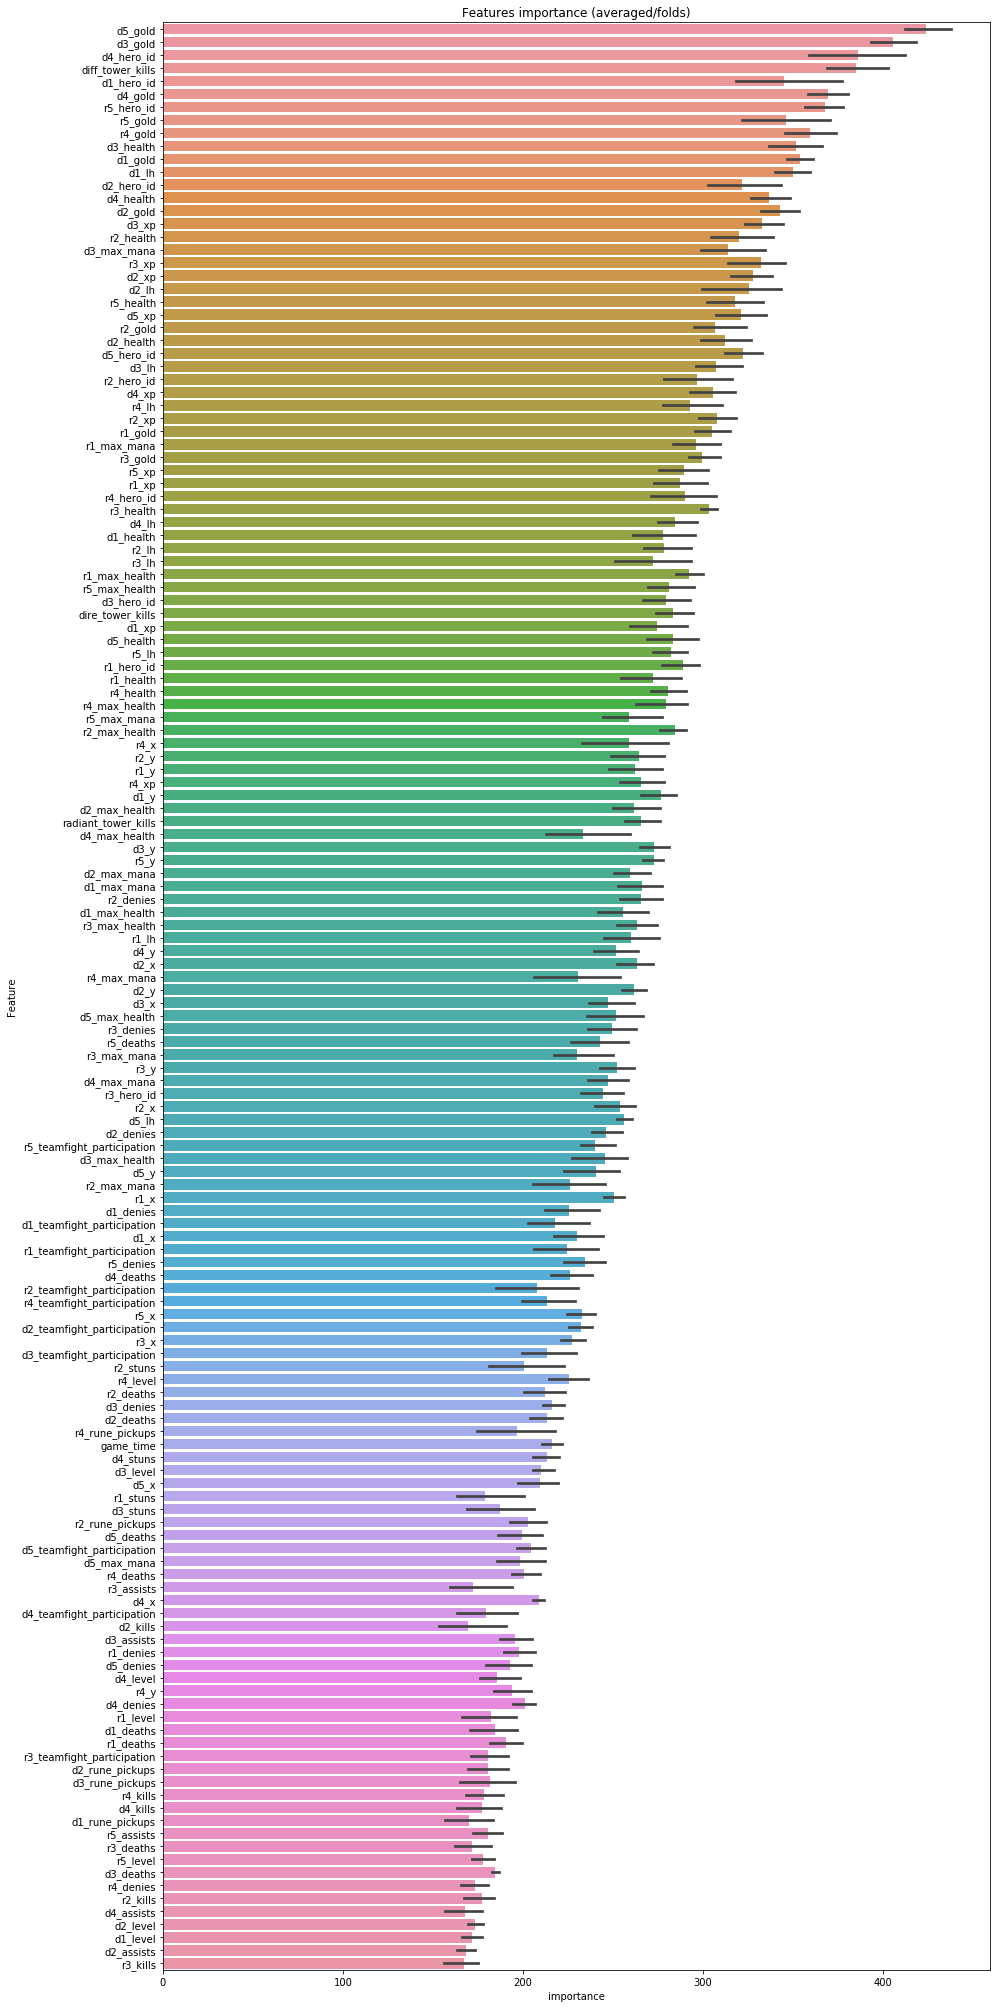

In [23]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FeatureImportance.png')

From the feature importance chart, we can see that the "gold" features play significant role in winning the game.

## <a id='5'>Predictions</a>

In [24]:
df_submission = pd.DataFrame({'radiant_win_prob': predictions}, 
                                 index=df_test_features.index)

submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-03-25_01-08-39.csv
